In [1]:

import re
import numpy as np
import pandas as pd
import seaborn as sns

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import nltk
nltk.download('wordnet') 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jelly\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jelly\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import pandas as pd
waitrose_df = pd.read_json(r'C:\Users\Jelly\Downloads\吴懿涛\waitrose.json')
waitrose_df['origintext'] = waitrose_df['text'].copy()

# Make sure the date field is of type datetime
waitrose_df['created_at'] = pd.to_datetime(waitrose_df['created_at'])
# Filter out data after September 2020
waitrose_df = waitrose_df[waitrose_df['created_at'] > pd.to_datetime('2020-09-01')]

waitrose_df.head()

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,display_text_range,retweeted_status,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,extended_entities,scopes,origintext
1,2020-11-17 16:31:19,1328737494000000000,1328737494000000000,@HOOODINIIII @roh17h @Samuel51 @sainsburys @Ma...,"<a href=""http://twitter.com/download/iphone"" r...",False,1.328654e+18,1.328654e+18,1.327758e+18,1.327758e+18,...,"[57, 133]",None,NaN,NaN,NaN,None,None,None,NaN,@HOOODINIIII @roh17h @Samuel51 @sainsburys @Ma...
3,2020-11-13 09:21:04,1327179666000000256,1327179666000000256,RT @jlandpartners: This Christmas we want to #...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,NaN,NaN,NaN,...,None,{'created_at': 'Fri Nov 13 07:00:00 +0000 2020...,NaN,NaN,NaN,None,None,None,NaN,RT @jlandpartners: This Christmas we want to #...
6,2020-10-22 19:30:51,1319360588000000000,1319360588000000000,@DrJDrooghaag @GeekOnTheLoose @digitalcloudgal...,"<a href=""http://twitter.com/download/iphone"" r...",True,1.319337e+18,1.319337e+18,3.429955e+09,3.429955e+09,...,"[117, 140]",None,0.0,NaN,NaN,None,None,None,NaN,@DrJDrooghaag @GeekOnTheLoose @digitalcloudgal...
9,2020-10-01 07:57:48,1311576032000000000,1311576032000000000,@mcgjingsorbust @waitrose We used to enjoy the...,"<a href=""http://twitter.com/download/android"" ...",True,1.307990e+18,1.307990e+18,1.245269e+18,1.245269e+18,...,"[26, 140]",None,NaN,NaN,NaN,None,None,None,NaN,@mcgjingsorbust @waitrose We used to enjoy the...
13,2020-09-27 07:19:55,1310116948000000000,1310116948000000000,@waitrose could you please tell me what feed i...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,NaN,4.632874e+07,4.632874e+07,...,None,None,NaN,NaN,NaN,None,None,None,NaN,@waitrose could you please tell me what feed i...


In [3]:
# Select specific columns from the original DataFrame
waitrose_df1 = waitrose_df[['created_at', 'id', 'text', 'favorite_count','origintext']]

# Filter out retweets by excluding rows where the 'text' column starts with 'RT'
waitrose_df1 = waitrose_df1[~waitrose_df1['text'].str.startswith('RT')]

waitrose_df1.head()


,created_at,id,text,favorite_count,origintext
1,2020-11-17 16:31:19,1328737494000000000,@HOOODINIIII @roh17h @Samuel51 @sainsburys @Ma...,1,@HOOODINIIII @roh17h @Samuel51 @sainsburys @Ma...
6,2020-10-22 19:30:51,1319360588000000000,@DrJDrooghaag @GeekOnTheLoose @digitalcloudgal...,4,@DrJDrooghaag @GeekOnTheLoose @digitalcloudgal...
9,2020-10-01 07:57:48,1311576032000000000,@mcgjingsorbust @waitrose We used to enjoy the...,0,@mcgjingsorbust @waitrose We used to enjoy the...
13,2020-09-27 07:19:55,1310116948000000000,@waitrose could you please tell me what feed i...,0,@waitrose could you please tell me what feed i...
24,2020-12-13 10:55:02,1338074948000000000,Come. On.\nIsn't it time Supermarkets committe...,0,Come. On.\nIsn't it time Supermarkets committe...


In [4]:
print ('The length of the dataset is %s'%len(waitrose_df1))
print ('The begining date of the dataset is %s'%(str(min(waitrose_df1['created_at']))))
print ('The ending date of the dataset is %s'%(str(max(waitrose_df1['created_at']))))
print ("There are %s columns in this dataset"%(len(waitrose_df1.columns.values)))
waitrose_df1.columns.values

The length of the dataset is 4705
The begining date of the dataset is 2020-09-01 03:51:35
The ending date of the dataset is 2020-12-30 22:59:15
There are 5 columns in this dataset


array(['created_at', 'id', 'text', 'favorite_count', 'origintext'],
      dtype=object)

In [5]:
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
import numpy as np
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
# Data Preprocessing Functions
def to_lower(text):
    return text.lower()

def remove_mentions(text):
    return re.sub(r'@\w+', '', text)
waitrose_df1['text'] = waitrose_df1['text'].apply(lambda x: remove_mentions(x))


def remove_url(text):
    return re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\'(),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
waitrose_df1['text'] = waitrose_df1['text'].apply(lambda x: remove_url(x))

def remove_email(text):
    return re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
waitrose_df1['text'] = waitrose_df1['text'].apply(lambda x: remove_email(x))

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)
waitrose_df1['text'] = waitrose_df1['text'].apply(lambda x: remove_punctuation(x))



waitrose_df1.head()

,created_at,id,text,favorite_count,origintext
1,2020-11-17 16:31:19,1328737494000000000,I go to toobut Ill definitely be shoppin...,1,@HOOODINIIII @roh17h @Samuel51 @sainsburys @Ma...
6,2020-10-22 19:30:51,1319360588000000000,,4,@DrJDrooghaag @GeekOnTheLoose @digitalcloudgal...
9,2020-10-01 07:57:48,1311576032000000000,We used to enjoy the Waitrose Leckford Free ...,0,@mcgjingsorbust @waitrose We used to enjoy the...
13,2020-09-27 07:19:55,1310116948000000000,could you please tell me what feed is used fo...,0,@waitrose could you please tell me what feed i...
24,2020-12-13 10:55:02,1338074948000000000,Come On\nIsnt it time Supermarkets committed t...,0,Come. On.\nIsn't it time Supermarkets committe...


In [7]:
# Remove the word 'amp' from the 'text' column using a regular expression
waitrose_df1['text'] = waitrose_df1['text'].str.replace(r'\bamp\b', '', regex=True)


In [8]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

#Define custom stop words
custom_stop_words = ['hi', 'x', 'w']
# Merge nltk's English stop words and custom stop words
stop_words = set(stopwords.words('english')) | set(custom_stop_words)


lemmatizer = WordNetLemmatizer()

def remove_stopwords(text):
    # Use word_tokenize to split text into word lists
    words = word_tokenize(text)
    # Filter stopwords and filter out words with length greater than 2
    filtered_text = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words and len(word) > 2]
    # Recombine filtered words into strings
    return ' '.join(filtered_text)

waitrose_df1['text'] = waitrose_df1['text'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jelly\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jelly\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jelly\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:

waitrose_df1['text'] = waitrose_df1['text'].str.strip()

# Replace empty string with NaN
waitrose_df1['text'].replace('', pd.NA, inplace=True)

# Delete rows containing NaN
waitrose_df1.dropna(subset=['text'], inplace=True)

waitrose_df1.head()


,created_at,id,text,favorite_count,origintext
1,2020-11-17 16:31:19,1328737494000000000,toobut ill definitely shopping,1,@HOOODINIIII @roh17h @Samuel51 @sainsburys @Ma...
9,2020-10-01 07:57:48,1311576032000000000,used enjoy waitrose leckford free range chicke...,0,@mcgjingsorbust @waitrose We used to enjoy the...
13,2020-09-27 07:19:55,1310116948000000000,could please tell feed used meat product come ...,0,@waitrose could you please tell me what feed i...
24,2020-12-13 10:55:02,1338074948000000000,come isnt time supermarket committed exclusive...,0,Come. On.\nIsn't it time Supermarkets committe...
42,2020-12-29 18:59:06,1343994972000000000,waitrose basically funnel everybody wee tight ...,0,@Marydawl83 @waitrose @Marydawl83 Waitrose bas...


In [10]:
from nltk.corpus import opinion_lexicon
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
nltk.download('opinion_lexicon')
positive_wds = set(opinion_lexicon.positive())
negative_wds = set(opinion_lexicon.negative())


[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\Jelly\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [11]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

waitrose_df1['rating'] = waitrose_df1['text'].apply(sia.polarity_scores)

# Define a lambda function to extract the 'compound' score from the ratings
get_value = lambda d: d['compound']
waitrose_df1["sentiment_score"] = waitrose_df1["rating"].apply(get_value)

# Define a function to categorize the sentiment based on the compound score
def fun(waitrose_df1):
  if waitrose_df1["sentiment_score"] > 0:
    return 'positive'
  if waitrose_df1["sentiment_score"] < 0:
    return 'negative'
  return 'neutral'

# Apply the sentiment categorization function across the DataFrame rows
waitrose_df1["sentiment"]=waitrose_df1.apply(fun, axis=1)

waitrose_df1.head()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Jelly\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,created_at,id,text,favorite_count,origintext,rating,sentiment_score,sentiment
1,2020-11-17 16:31:19,1328737494000000000,toobut ill definitely shopping,1,@HOOODINIIII @roh17h @Samuel51 @sainsburys @Ma...,"{'neg': 0.373, 'neu': 0.267, 'pos': 0.36, 'com...",-0.0258,negative
9,2020-10-01 07:57:48,1311576032000000000,used enjoy waitrose leckford free range chicke...,0,@mcgjingsorbust @waitrose We used to enjoy the...,"{'neg': 0.132, 'neu': 0.417, 'pos': 0.451, 'co...",0.6808,positive
13,2020-09-27 07:19:55,1310116948000000000,could please tell feed used meat product come ...,0,@waitrose could you please tell me what feed i...,"{'neg': 0.0, 'neu': 0.574, 'pos': 0.426, 'comp...",0.6369,positive
24,2020-12-13 10:55:02,1338074948000000000,come isnt time supermarket committed exclusive...,0,Come. On.\nIsn't it time Supermarkets committe...,"{'neg': 0.185, 'neu': 0.815, 'pos': 0.0, 'comp...",-0.2057,negative
42,2020-12-29 18:59:06,1343994972000000000,waitrose basically funnel everybody wee tight ...,0,@Marydawl83 @waitrose @Marydawl83 Waitrose bas...,"{'neg': 0.0, 'neu': 0.864, 'pos': 0.136, 'comp...",0.0258,positive


In [12]:


# Output dataset information
print('The length of the dataset is %s' % len(waitrose_df1))
if 'created_at' in waitrose_df1.columns:
    print('The beginning date of the dataset is %s' % str(min(waitrose_df1['created_at'])))
    print('The ending date of the dataset is %s' % str(max(waitrose_df1['created_at'])))
print("There are %s columns in this dataset" % len(waitrose_df1.columns.values))
waitrose_df1.columns.values


The length of the dataset is 4068
The beginning date of the dataset is 2020-09-01 03:51:35
The ending date of the dataset is 2020-12-30 22:59:15
There are 8 columns in this dataset


array(['created_at', 'id', 'text', 'favorite_count', 'origintext',
       'rating', 'sentiment_score', 'sentiment'], dtype=object)

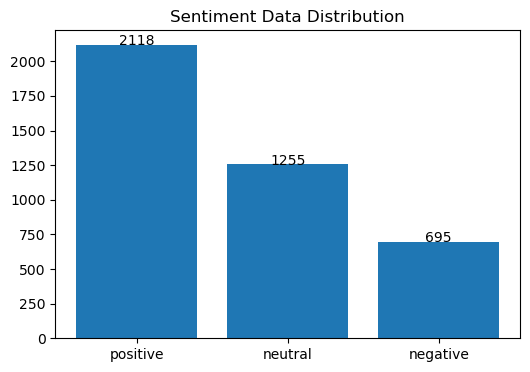

In [13]:
# Get the counts of unique values in the 'sentiment' column
val=waitrose_df1['sentiment'].value_counts()

x=val.index
y=val.values
plt.figure(figsize=(6,4))
plt.bar(x, y)
plt.title("Sentiment Data Distribution")

# Loop over the data points; 'a' and 'b' are the x and y values, 'i' is the index
# This loop is used to place text labels on top of the bars
for a,b,i in zip(x,y,range(len(x))): 
    plt.text(a,b+0.01,"%.0f"%y[i],ha='center',fontsize=10) 
    

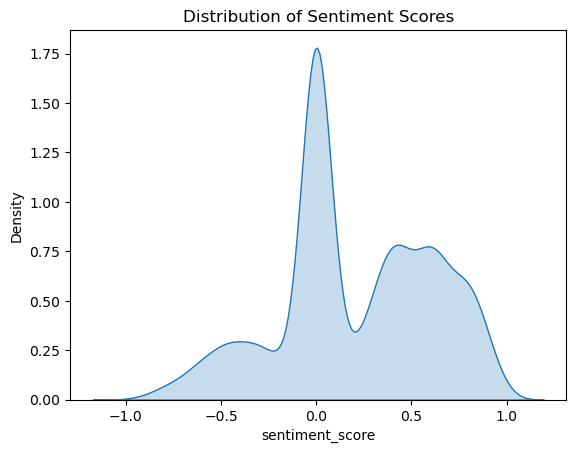

In [14]:
# Create a KDE plot for the 'sentiment_score' column from the DataFrame
sns.kdeplot(data=waitrose_df1, x='sentiment_score', label='sentiment_score', fill=True)
plt.title("Distribution of Sentiment Scores")
plt.show()

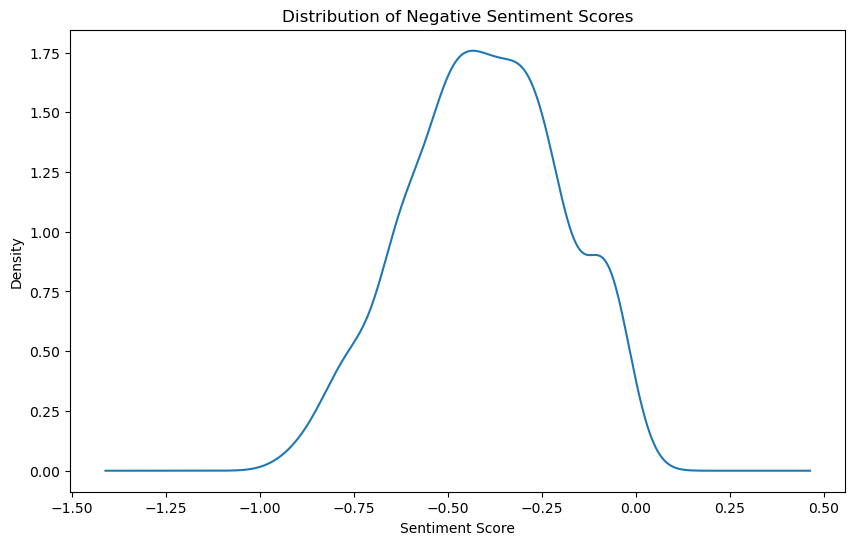

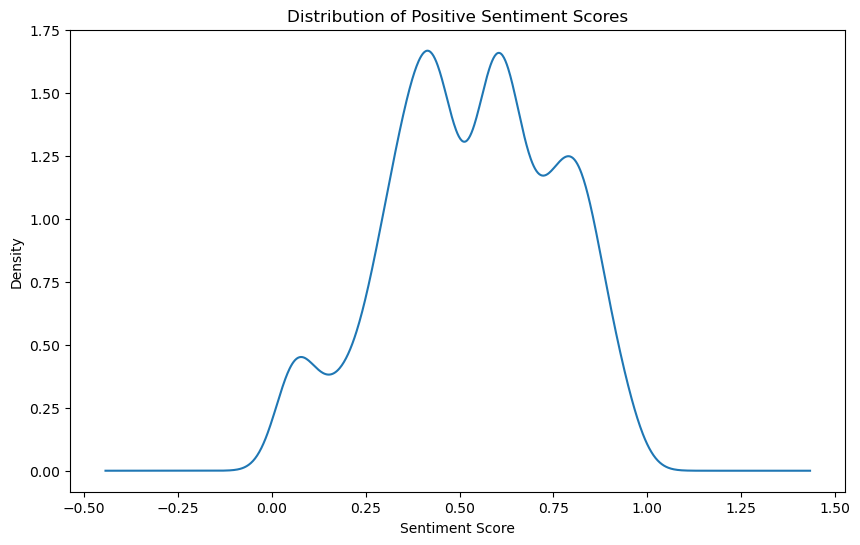

In [15]:
import matplotlib.pyplot as plt

# The first picture: Negative sentiment score distribution
plt.figure(figsize=(10, 6))
waitrose_df1[waitrose_df1.sentiment=="negative"]['sentiment_score'].plot.kde()
plt.title("Distribution of Negative Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.show()

# The second picture: Positive sentiment score distribution
plt.figure(figsize=(10, 6))
waitrose_df1[waitrose_df1.sentiment=="positive"]['sentiment_score'].plot.kde()
plt.title("Distribution of Positive Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.show()


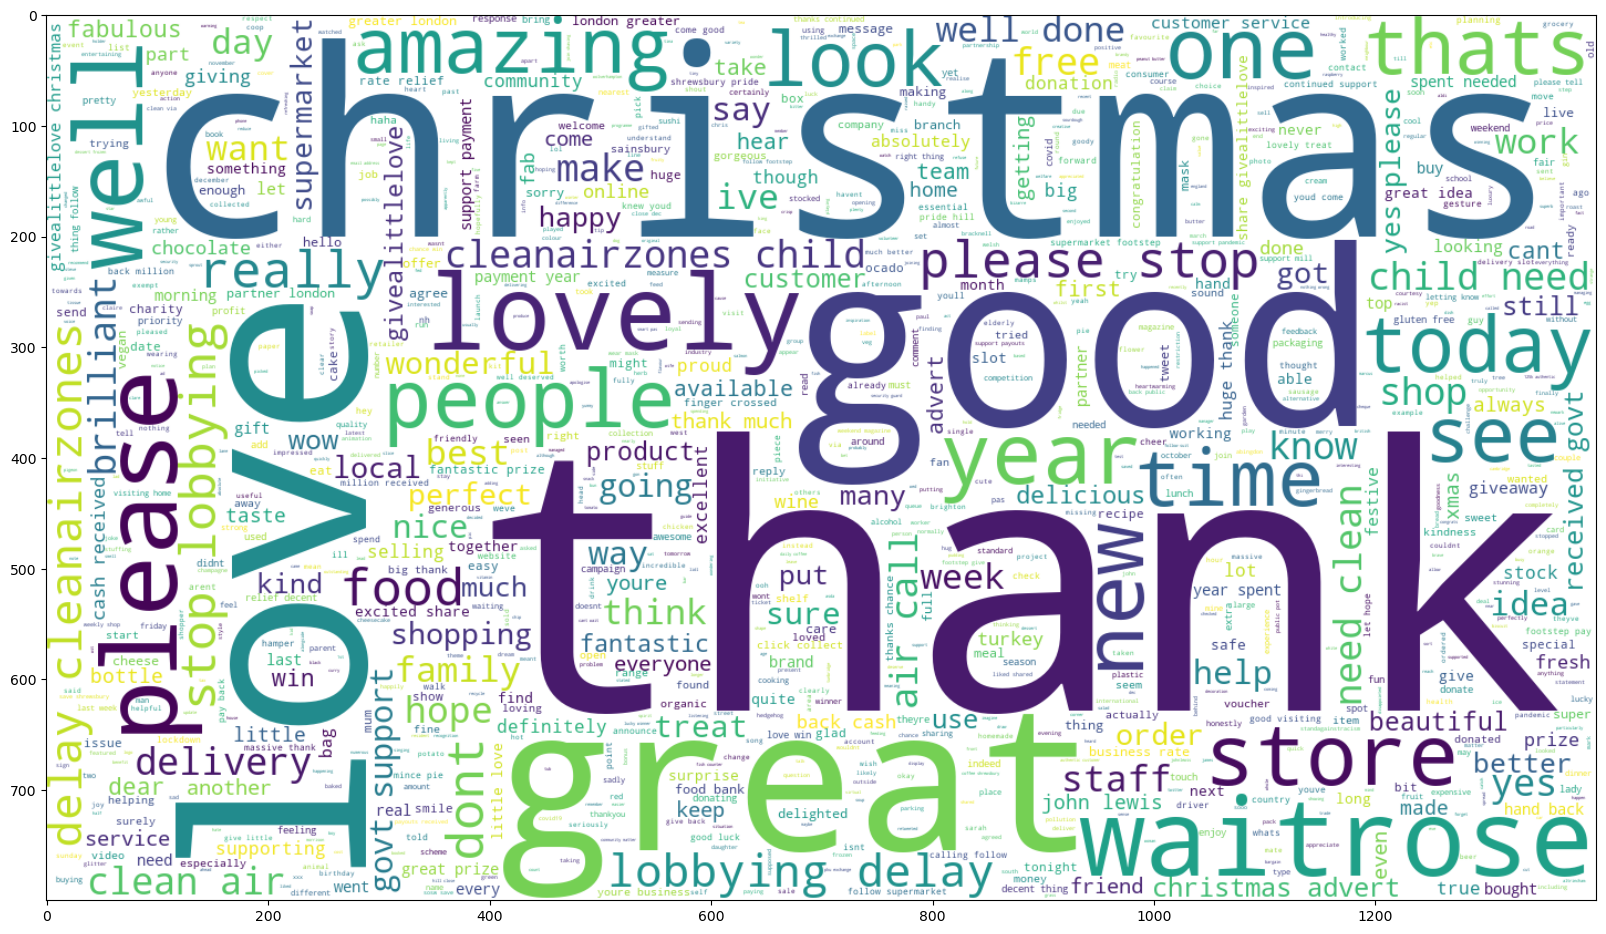

In [16]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(background_color = 'white',max_words = 2000 , width = 1400 , height = 800).generate(" ".join(waitrose_df1[waitrose_df1.sentiment == 'positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

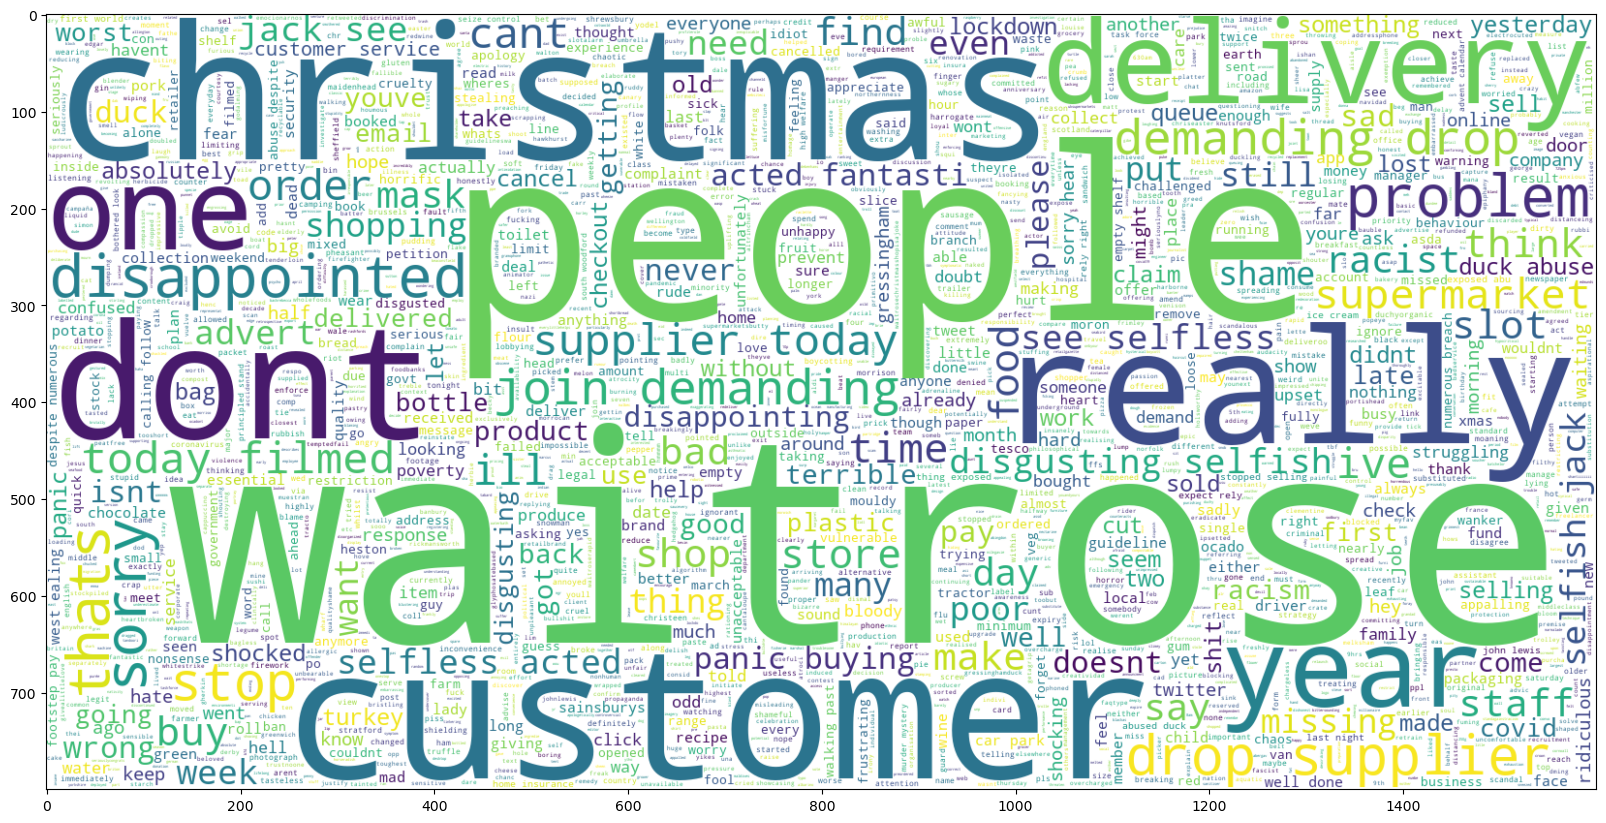

In [17]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(background_color = 'white',max_words = 2000 , width = 1600 , height = 800).generate(" ".join(waitrose_df1[waitrose_df1.sentiment == 'negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

In [18]:

import pandas as pd
import unicodedata
import re
import contractions
import string
#Gensim
import gensim
import gensim.corpora as corpora
#spacy
import spacy
#vis
import pyLDAvis
import pyLDAvis.gensim_models

In [19]:
def generate_tokens(tweet):
    words=[]
    for word in tweet.split(' '):
    # using the if condition because we introduced extra spaces during text cleaning
        if word!='':
           words.append(word)
    return words
#storing the generated tokens in a new column named 'tokens'
waitrose_df1['tokens']=waitrose_df1.text.apply(generate_tokens)
waitrose_df1.head()

,created_at,id,text,favorite_count,origintext,rating,sentiment_score,sentiment,tokens
1,2020-11-17 16:31:19,1328737494000000000,toobut ill definitely shopping,1,@HOOODINIIII @roh17h @Samuel51 @sainsburys @Ma...,"{'neg': 0.373, 'neu': 0.267, 'pos': 0.36, 'com...",-0.0258,negative,"[toobut, ill, definitely, shopping]"
9,2020-10-01 07:57:48,1311576032000000000,used enjoy waitrose leckford free range chicke...,0,@mcgjingsorbust @waitrose We used to enjoy the...,"{'neg': 0.132, 'neu': 0.417, 'pos': 0.451, 'co...",0.6808,positive,"[used, enjoy, waitrose, leckford, free, range,..."
13,2020-09-27 07:19:55,1310116948000000000,could please tell feed used meat product come ...,0,@waitrose could you please tell me what feed i...,"{'neg': 0.0, 'neu': 0.574, 'pos': 0.426, 'comp...",0.6369,positive,"[could, please, tell, feed, used, meat, produc..."
24,2020-12-13 10:55:02,1338074948000000000,come isnt time supermarket committed exclusive...,0,Come. On.\nIsn't it time Supermarkets committe...,"{'neg': 0.185, 'neu': 0.815, 'pos': 0.0, 'comp...",-0.2057,negative,"[come, isnt, time, supermarket, committed, exc..."
42,2020-12-29 18:59:06,1343994972000000000,waitrose basically funnel everybody wee tight ...,0,@Marydawl83 @waitrose @Marydawl83 Waitrose bas...,"{'neg': 0.0, 'neu': 0.864, 'pos': 0.136, 'comp...",0.0258,positive,"[waitrose, basically, funnel, everybody, wee, ..."


In [20]:
def create_dictionary(words):
    return corpora.Dictionary(words)
id2word=create_dictionary(waitrose_df1['tokens'])
print(id2word)

Dictionary<6089 unique tokens: ['definitely', 'ill', 'shopping', 'toobut', 'chicken']...>


In [21]:
def create_document_matrix(tokens,id2word):
    corpus = []
    for text in tokens:
        corpus.append(id2word.doc2bow(text))
    return corpus
#passing the dataframe column having tokens and dictionary
corpus=create_document_matrix(waitrose_df1['tokens'],id2word)


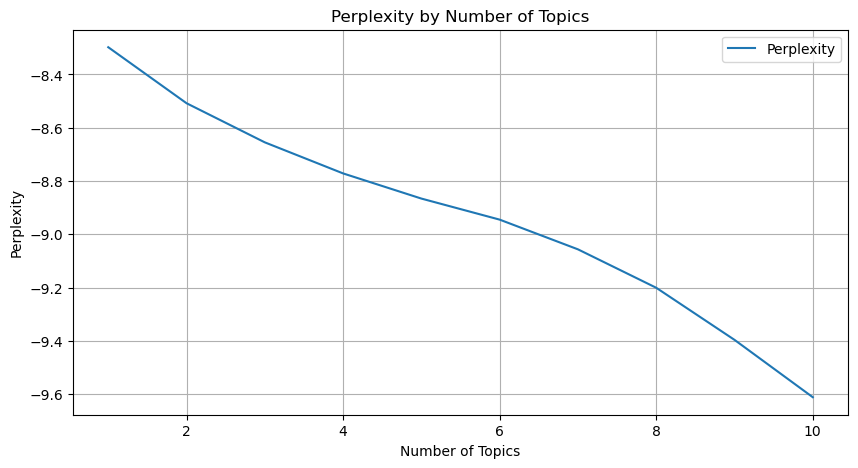

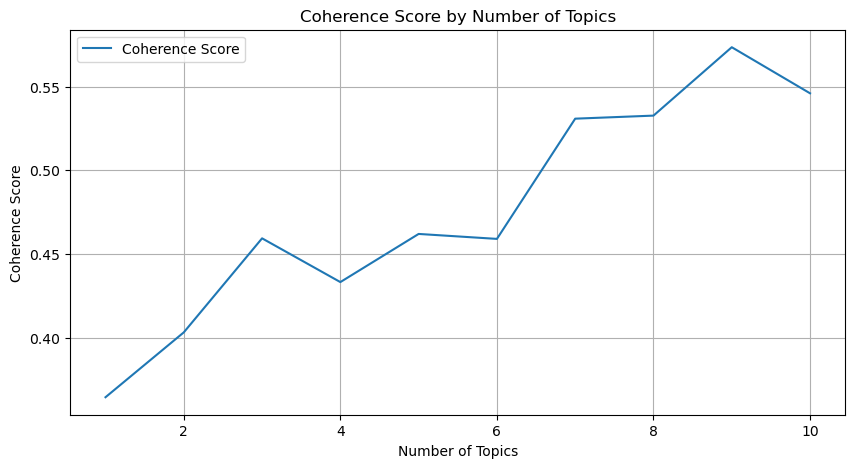

In [26]:
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel, LdaModel
from gensim.corpora.dictionary import Dictionary


dictionary = Dictionary(waitrose_df1['tokens'])


corpus = [dictionary.doc2bow(text) for text in waitrose_df1['tokens']]

#Number of different topics to try
topic_nums = range(1, 11) 


perplexities = []
coherences = []

for num_topics in topic_nums:
    # Train LDA model
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100)
    
    # Calculate confusion
    perplexity = lda_model.log_perplexity(corpus)
    perplexities.append(perplexity)
    
    # Calculate coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=waitrose_df1['tokens'].tolist(), dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherences.append(coherence_lda)


plt.figure(figsize=(10, 5))
plt.plot(topic_nums, perplexities, label='Perplexity')
plt.title('Perplexity by Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.legend()
plt.grid(True)


plt.figure(figsize=(10, 5))
plt.plot(topic_nums, coherences, label='Coherence Score')
plt.title('Coherence Score by Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.legend()
plt.grid(True)

plt.show()


In [27]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=9, random_state=100)

In [28]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

c:\Users\Jelly\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.078487 -0.030351       1        1  14.834275
4      0.066361  0.077630       2        1  13.470668
3     -0.061848  0.256729       3        1  11.202709
5     -0.244732 -0.151745       4        1  11.046316
1     -0.039164 -0.200369       5        1  10.822749
6     -0.200504  0.122300       6        1  10.519915
7      0.155301 -0.215342       7        1   9.936353
8      0.227940 -0.037005       8        1   9.528730
0      0.175134  0.178154       9        1   8.638286, topic_info=            Term       Freq       Total Category  logprob  loglift
1282    supplier  76.000000   76.000000  Default  30.0000  30.0000
1192         guy  70.000000   70.000000  Default  29.0000  29.0000
2843  ridiculous  66.000000   66.000000  Default  28.0000  28.0000
701       london  66.000000   66.000000  Default  27.0000  27.0000
343         jack  65.000000   65.000000  Default  26.0000  26.0000
...          ...        ...         ...      ...      ...      ...
623        sorry  14.270755   78.069479   Topic9  -5.0283   0.7496
12      waitrose  23.697897  251.601576   Topic9  -4.5211   0.0865
624         help   9.053603   43.679355   Topic9  -5.4833   0.8753
90          stop  12.020442  123.233301   Topic9  -5.1999   0.1215
71          good  10.225807   82.085422   Topic9  -5.3616   0.3661

[437 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
3068      9  0.970546    150
411       1  0.048096   2020
411       2  0.144287   2020
411       5  0.096191   2020
411       6  0.048096   2020
...     ...       ...    ...
389       9  0.019817  youre
944       1  0.075976  youve
944       2  0.075976  youve
944       3  0.025325  youve
944       7  0.810415  youve

[1184 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 6, 2, 7, 8, 9, 1])